# Agent based model of infection spread
### Author: Kirill Zakharov

In [320]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, HBox, Label
import numpy as np
import random
from random import uniform
from math import sqrt
import matplotlib.pyplot as plt
from IPython.display import display
from enum import Enum
from scipy.integrate import odeint
%matplotlib inline

## The main code of the model

In [332]:
np.random.seed(1)

class Status(Enum):
    #Agent status
    Susceptible = 's'
    Infected = 'i'
    Healthy = 'h'
    Recovered = 'r'

class Immunity(Enum):
    #Agent immunity to infection
    High_Immunity = 'hi'
    Middle_Immunity = 'mi'
    Low_Immunity = 'li'
    
class JobStatus(Enum):
    #Agent's job status
    Work = 'w'
    Not_Work = 'nw'
    Study = 'st'
    Not_Study = 'nst'
    Retired = 'rt'
    
class Agent:

    def __init__(self, **kwargs):
        self.status = kwargs.get("status", Status.Susceptible) #one from three possible status
        self.immunity = kwargs.get("immunity", Immunity.Middle_Immunity) #one from three possible immunity
        self.x = kwargs.get("x", 0.1) #postition X
        self.y = kwargs.get("y", 0.1) #position Y
        self.k = kwargs.get("k", 5) #the number of contacts
        self.age = kwargs.get("age", 30) #age of the agent
        self.job_status = kwargs.get("job_status", JobStatus.Not_Work)
        
        self.location = (self.x, self.y)
        self.isolated = []
        self.inf_prec = 50
        self.home_s = True
        self.time = 0
        

    def change_location(self):
        self.x, self.y = round(uniform(0, 1),4), round(uniform(0, 1),4)
        self.location = (self.x, self.y)

    def _distance(self, other):
        return sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    

    def near_people(self, agents): #find the near k people 
        distances = []
        for agent in agents[:self.k]:
            if self != agent:
                dist = self._distance(agent)
                distances.append((dist, agent))
        distances.sort(key=lambda x: x[0])
        nears = [(d, agent) for d, agent in distances] #sorted by the distances

        return nears
    
    def home_status(self, time):
        #determine the home time
        if time < 9 or time > 21:
            return True
        else:
            return False
        
    
    def test_infection(self): #this function only for suspicious agents, checks for infection
        test_infection = random.randint(0, 100)
        if test_infection >= self.inf_prec:
            return True #if the test is positive
        else:
            return False
    
    def inf_check(self, delta, agents): #if the distance less than delta the agent is infected
        nears = self.near_people(agents)
        for near in nears:
            if near[0] <= delta and self.immunity.value == 'li':
                self.status = Status.Infected
                
            elif near[0] <= delta and self.immunity.value == 'mi':
                if self.status.value == 'h':
                    self.status = Status.Susceptible
                elif self.status.value == 's':
                    self.status = Status.Infected
                else:
                    return
                
            elif near[0] <= delta and self.immunity.value == 'hi':
                if self.status.value == 'h':
                    self.status = Status.Susceptible
                    self.immunity = Immunity.Middle_Immunity
                elif self.status.value == 's':
                    self.immunity = Immunity.Low_Immunity
                else:
                    return
            elif near[0] > delta and self.immunity.value == 'hi' and self.test_infection():
                if self.status.value == 's':
                    self.status = Status.Healthy
                else:
                    return
            else:
                return
        return
        
    
    def move(self, delta, population): #the main function for moving on the map
#         self.time += 1
        self.time = random.randint(0, 24)
        self.home_s = self.home_status(self.time)
        self.change_location()
        if self.status.value != 'i' and self.status.value != 'r':
            self.inf_check(delta, population)
        if self.status.value == 's' and self not in self.isolated and not self.home_s:
            if self.test_infection():
                self.status = Status.Infected
            else:
                self.isolated.append(self)
        if self.status.value == 'i':
            if self.age > death_limit and self.immunity.value == 'li': #condition for death
                population.remove(self)
#             elif self.age > death_limit and self.immunity.value == 'hi' and self not in self.isolated:
#                 self.isolated.append(self)
#             else: return    

class Environmental(Agent):
    day = 24        

def create_agent(population, status): #function for creating one agent
        """
        Create a new agent
        """
        x, y = round(uniform(0, 1),4), round(uniform(0, 1),4) #position
        age = random.randint(1, 100) #age
        k = random.randint(0, 40) #the number of contacts
        immunity = random.choice([Immunity.High_Immunity, Immunity.Middle_Immunity, Immunity.Low_Immunity])
        job_status = ''
        if age < 7:
            job_status = JobStatus.Not_Study
        elif 7 <= age <= 24:
            job_status = JobStatus.Study
        elif 24 < age <= 65:
            job_status = random.choice([JobStatus.Work, JobStatus.Not_Work])
        else:
            job_status = JobStatus.Retired
        
        population.append(Agent(x=x, y=y, age=age, k=k, status=status, immunity=immunity, job_status=job_status))
        return
        
def initialize(population, num_p, num_inf): #create the population
        # Initial infected population
        for _ in range(num_p*num_inf//100):
            create_agent(population, Status.Infected)

        # Initial healthy population
        for _ in range((num_p - len(population))//2):
            create_agent(population, Status.Healthy)

        # Initial suspicious population
        for _ in range(num_p - len(population)):
            create_agent(population, Status.Susceptible)
        
        return
        

    

## The setting of parameters

In [338]:
style = {'description_width': 'initial'}
num_p = widgets.IntText(
    value = 1000,
    description="The number of population", style=style)
display(num_p)

num_inf = widgets.IntSlider(
    value=7,
    min=0,
    max=100,
    step=1,
    description='Percent of infected people',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)

display(num_inf)

delta = widgets.FloatSlider(
    value=0.04,
    min=0,
    max=0.1,
    step=0.01,
    description='The velocity of spread',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    style=style
)
display(delta)

recovery_time = widgets.IntText(
    value = 4,
    description="Recovery time",
    style=style)
display(recovery_time)


# button = widgets.Button(description="Simulate", button_style='info')
# output = widgets.Output()
# display(button, output)

population = []

# button.on_click(initialize(population, num_p.value, num_inf.value))

IntText(value=1000, description='The number of population', style=DescriptionStyle(description_width='initial'…

IntSlider(value=7, continuous_update=False, description='Percent of infected people', style=SliderStyle(descri…

FloatSlider(value=0.04, continuous_update=False, description='The velocity of spread', max=0.1, step=0.01, sty…

IntText(value=4, description='Recovery time', style=DescriptionStyle(description_width='initial'))

## Initialization of the population

In [339]:
death_limit = random.randint(80, 100)
initialize(population, num_p.value, num_inf.value) #creating the population
len(population)

1000

## Visualization

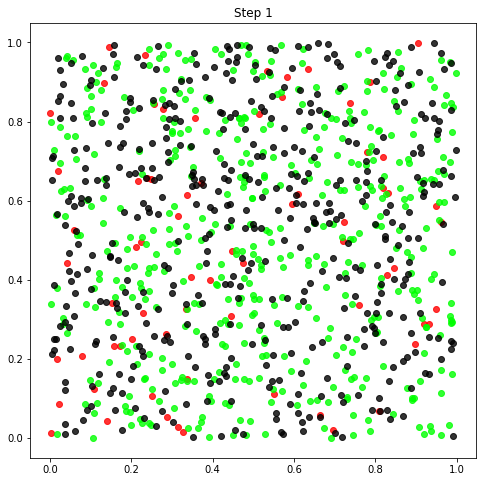

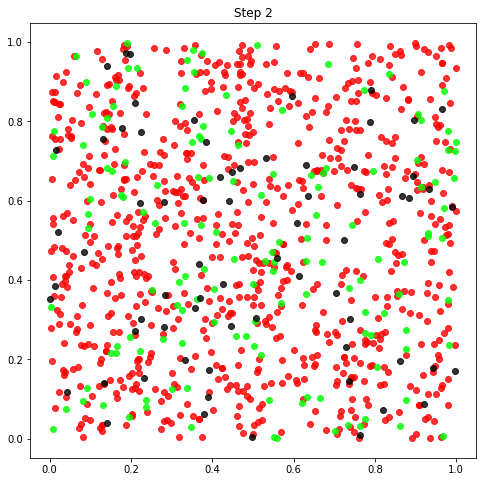

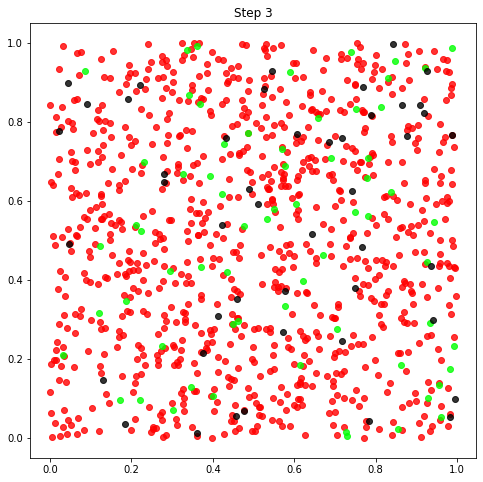

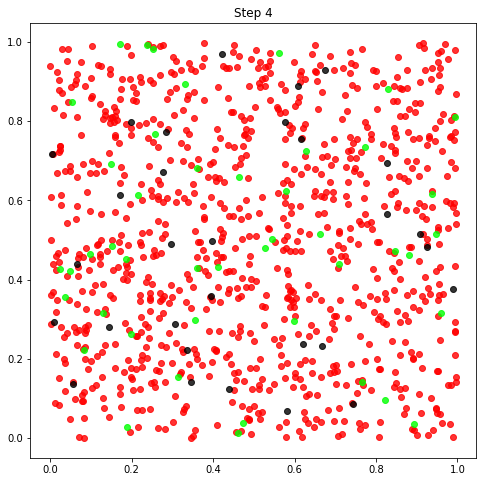

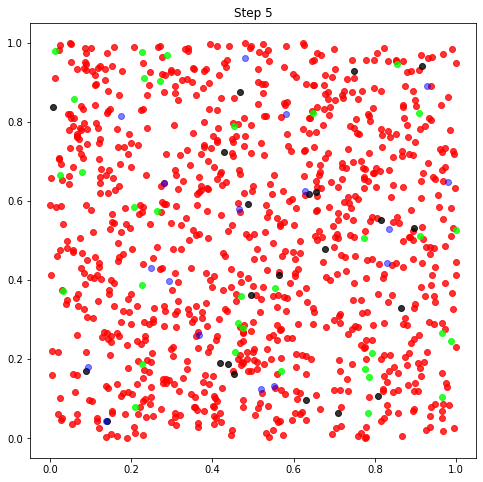

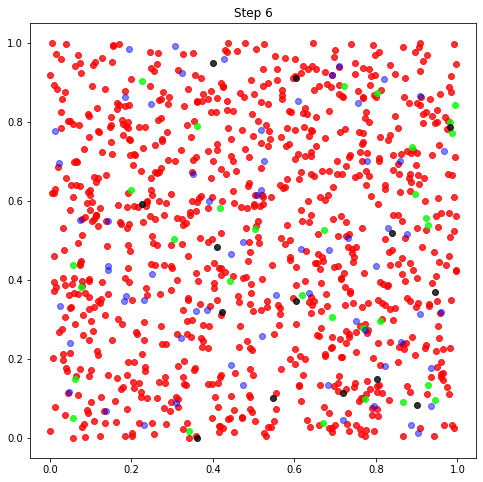

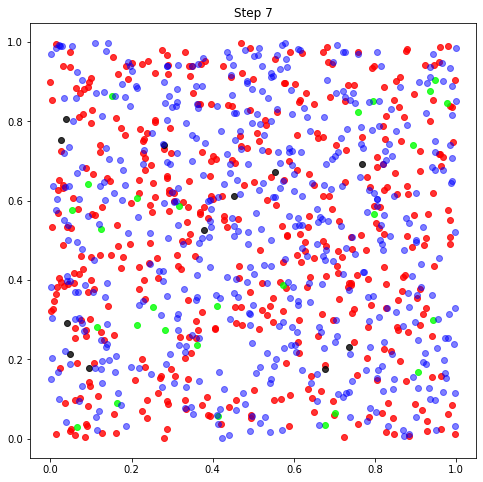

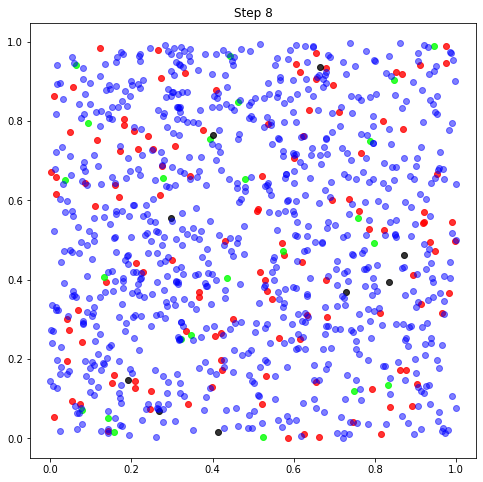

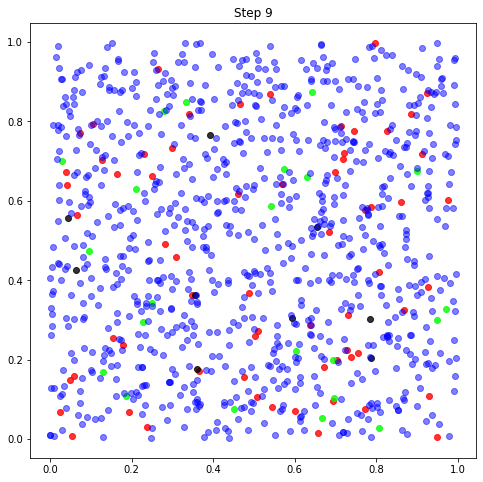

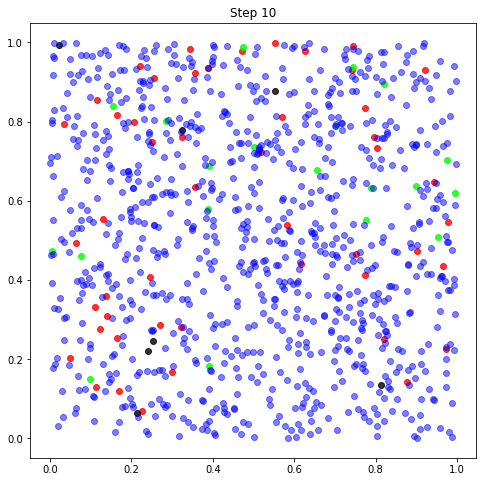

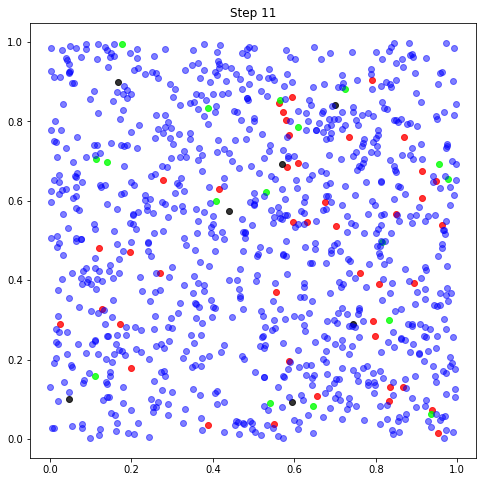

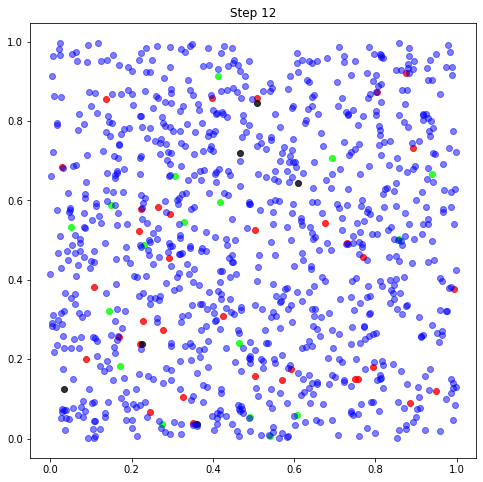

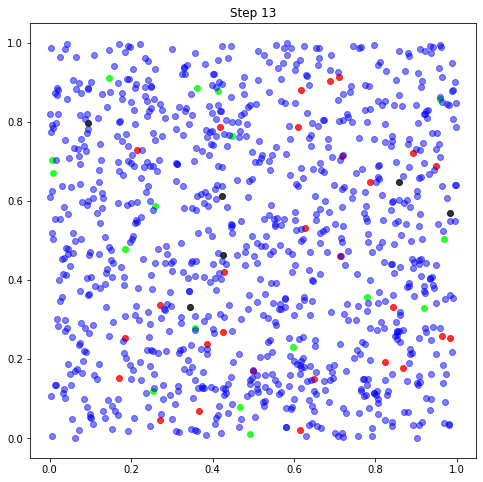

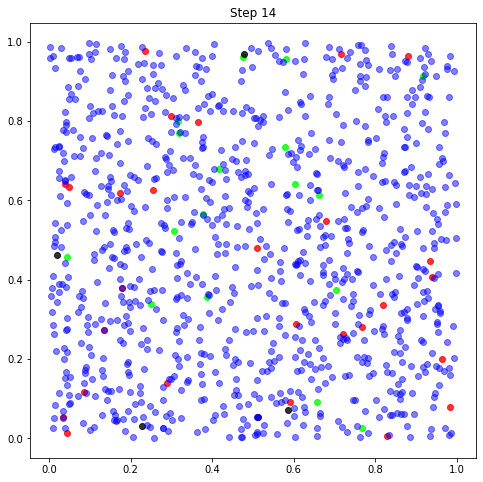

In [335]:
def plot_distribution(population, cycle_num):
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    x_values_2, y_values_2 = [], []
    x_values_3, y_values_3 = [], []
    for agent in population:
        x, y = agent.location
        if agent.status.value == 'i':
            x_values_0.append(x)
            y_values_0.append(y)
        elif agent.status.value == 'h':
            x_values_1.append(x)
            y_values_1.append(y)
        elif agent.status.value == 's':
            x_values_2.append(x)
            y_values_2.append(y)
        else:
            x_values_3.append(x)
            y_values_3.append(y)
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_args = {'markersize': 6, 'alpha': 0.8}
    ax.set_facecolor('white')
    ax.plot(x_values_0, y_values_0, 'o', c='red', **plot_args)
    ax.plot(x_values_1, y_values_1, 'o', c='lime', **plot_args)
    ax.plot(x_values_2, y_values_2, 'o', c='black', **plot_args)
    ax.plot(x_values_3, y_values_3, 'o', c='blue', alpha = 0.5)
    ax.set_title(f'Step {cycle_num}')
    plt.show()

count = 1
control = []
control1 = []
infected = []
counts = []
while True:
    healthy = []
    
    for agent in population:
        if agent.status.value == 'h' and agent not in healthy:
            healthy.append(agent)
        if agent.status.value == 'i' and agent.age < death_limit and agent not in infected:
            infected.append(agent)
            counts.append(count)
    # control some variables        
    control.append(len(infected))
    control1.append(counts)
    
#     if len(healthy) >= ((num_p - num_inf)//2)*10//100:
    if len(infected) >= num_p.value*1//100:
        plot_distribution(population, count)
        count += 1
        for _ in range(Environmental.day):
            for agent in population:
                agent.move(delta.value, population)
#                 infected_1 = list(zip(*infected))[0]
                if agent in infected and agent.immunity.value == 'hi':
                    pos = infected.index(agent)
#                     if counts[pos]%recovered_time == 0:
                    if (count - counts[pos]) >= recovery_time.value:
                        agent.status = Status.Recovered
                        infected.remove(agent)
                        counts.pop(pos)
                elif agent in infected and agent.immunity.value == 'mi':
                    pos = infected.index(agent)
#                     if counts[pos]%(recovered_time + 2) == 0:
                    if (count - counts[pos]) >= recovery_time.value + 1:
                        agent.status = Status.Recovered
                        infected.remove(agent)
                        counts.pop(pos)
                elif agent in infected and agent.immunity.value == 'li':
                    pos = infected.index(agent)
#                     if counts[pos]%(recovered_time + 2) == 0:
                    if (count - counts[pos]) >= recovery_time.value + 2:
                        agent.status = Status.Recovered
                        infected.remove(agent)
                        counts.pop(pos)
                    
                        
    else:
        break
#visualization with big contact rate        
plot_distribution(population, count)       

In [336]:
num_p.value - len(population) #the number of deaths

5

In [337]:
len(infected)

9

# Compare with SIR model

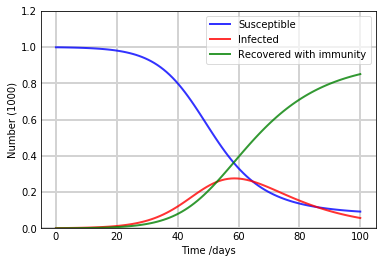

In [317]:
# Total population
N = num_p.value
# Initial number of infected and recovered individuals
I0, R0 = 1, 0
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (1/days)
beta, gamma = 0.2, 1/14 
# A grid of time points (in days)
t = np.linspace(0, 100, 100)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.8, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.8, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.8, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='lightgray', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.7)
plt.show()